# Suomi24 Corpus: Yearly Evolution of Hate and Friendly Speech

This notebook loads message data from PostgreSQL, aggregates yearly counts for hate speech (Query 1), friendly speech (Query 2), and both, and visualizes the results.

In [ ]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import os
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [3]:
# Connect to PostgreSQL using SQLAlchemy and load data into pandas DataFrame
db_user = os.environ.get("POSTGRES_USER", "postgres")
db_password = os.environ.get("POSTGRES_PASSWORD", "secret")
db_host = "localhost"
db_port = os.environ.get("POSTGRES_PORT", 5432)
db_name = os.environ.get("POSTGRES_DB", "suomi24")

# Create SQLAlchemy engine
engine = create_engine(f"postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}")

query = """
SELECT date, query_type, content FROM messages
WHERE date IS NOT NULL
"""
df = pd.read_sql(query, engine)

df['year'] = pd.to_datetime(df['date']).dt.year

In [4]:
# Aggregate yearly counts for each query type
agg = df.groupby(['year', 'query_type']).size().unstack(fill_value=0)
agg['both'] = agg.get('both', 0)
agg['hate'] = agg.get('hate', 0)
agg['friendly'] = agg.get('friendly', 0)
agg = agg[['hate', 'friendly', 'both']]
agg

query_type,hate,friendly,both
year,,,
2001,5010,5651,195
2002,9062,9975,363
2003,14735,17046,740
2004,26472,30145,1161
2005,39252,46480,1558
2006,50753,60523,2110
2007,45385,56975,1638
2008,46231,54311,1603
2009,49716,49926,1519


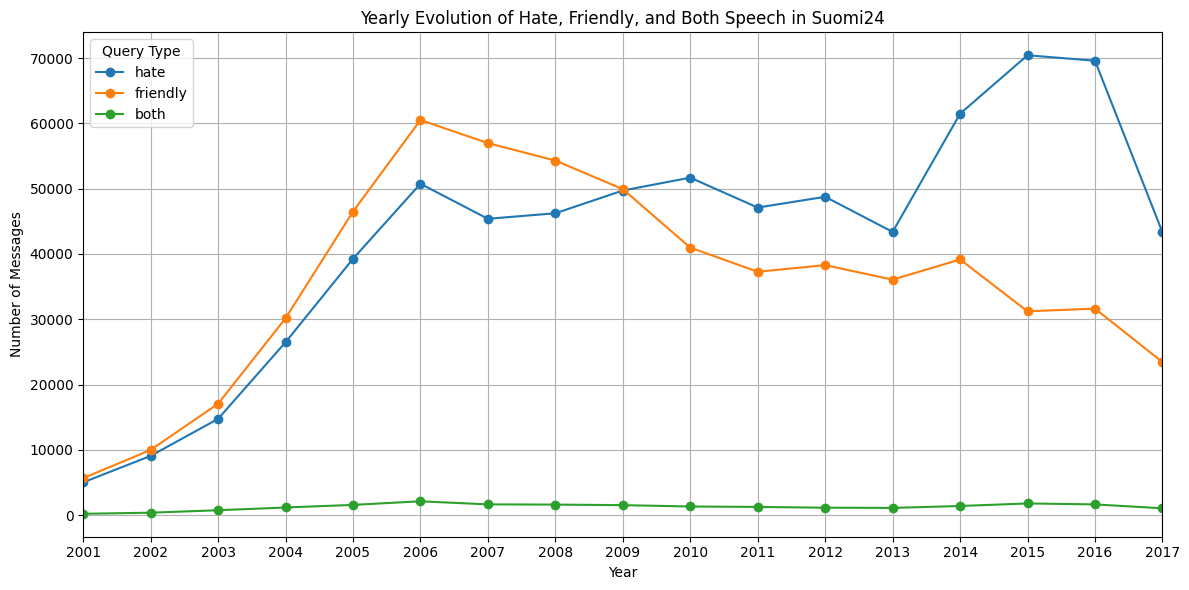

In [5]:
plt.figure(figsize=(12,6))
agg.plot(kind='line', marker='o', ax=plt.gca())
plt.title('Yearly Evolution of Hate, Friendly, and Both Speech in Suomi24')
plt.xlabel('Year')
plt.ylabel('Number of Messages')
plt.grid(True)
plt.legend(title='Query Type')
plt.xlim(2001, 2017)
plt.xticks(range(2001, 2018))
plt.tight_layout()
plt.show()

In [6]:
def get_avg_tokens_per_message(group):
    token_counts = []
    for content in group['content'].dropna():
        token_counts.append(len(content.split()))
    return sum(token_counts) / len(token_counts) if token_counts else 0

df_filtered = df[df['query_type'].isin(['hate', 'friendly'])]
avg_tokens = df_filtered.groupby(['year', 'query_type']).apply(get_avg_tokens_per_message, include_groups=False).unstack(fill_value=0)
avg_tokens

query_type,friendly,hate
year,,
2001,146.786763,153.383034
2002,181.155088,170.303355
2003,198.224979,183.154462
2004,185.736772,210.998262
2005,170.598171,181.377025
2006,181.068040,191.745434
2007,162.773146,170.740024
2008,158.301928,165.531591
2009,153.063855,139.921675


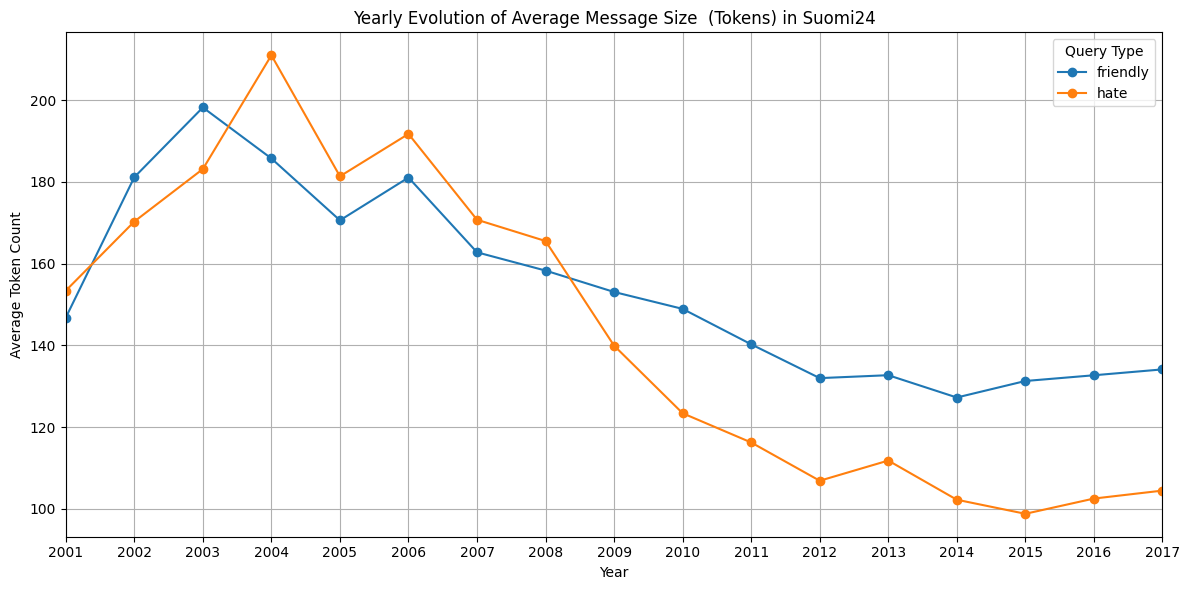

In [7]:
plt.figure(figsize=(12,6))
avg_tokens.plot(kind='line', marker='o', ax=plt.gca())
plt.title('Yearly Evolution of Average Message Size  (Tokens) in Suomi24')
plt.xlabel('Year')
plt.ylabel('Average Token Count')
plt.grid(True)
plt.legend(title='Query Type')
plt.xlim(2001, 2017)
plt.xticks(range(2001, 2018))
plt.tight_layout()
plt.show()

In [8]:
def get_avg_vocab_per_message(group):
    vocab_sizes = []
    for content in group['content'].dropna():
        unique_tokens = set(content.split())
        vocab_sizes.append(len(unique_tokens))
    return sum(vocab_sizes) / len(vocab_sizes) if vocab_sizes else 0

avg_vocab_per_message = df_filtered.groupby(['year', 'query_type']).apply(get_avg_vocab_per_message, include_groups=False).unstack(fill_value=0)

avg_vocab_per_message

query_type,friendly,hate
year,,
2001,99.088303,100.110978
2002,116.769323,109.047451
2003,124.384372,115.819070
2004,118.352695,125.629269
2005,110.076571,111.902909
2006,114.185913,112.300100
2007,106.485687,107.302347
2008,103.798291,103.745712
2009,103.077835,92.737328


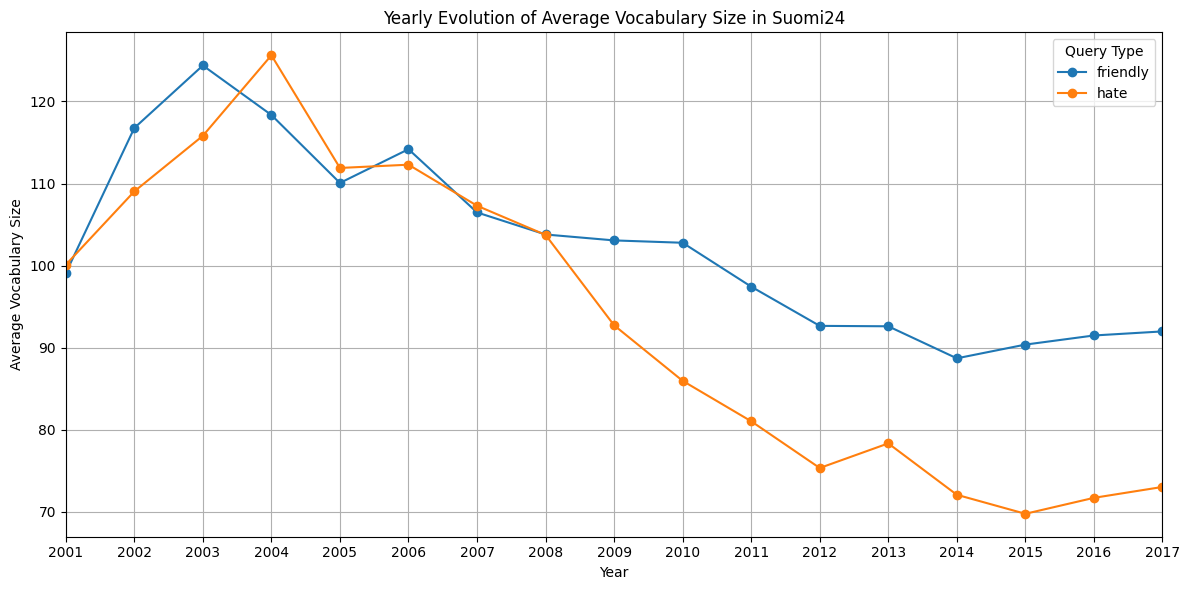

In [9]:
plt.figure(figsize=(12,6))
avg_vocab_per_message.plot(kind='line', marker='o', ax=plt.gca())
plt.title('Yearly Evolution of Average Vocabulary Size in Suomi24')
plt.xlabel('Year')
plt.ylabel('Average Vocabulary Size')
plt.grid(True)
plt.legend(title='Query Type')
plt.xlim(2001, 2017)
plt.xticks(range(2001, 2018))
plt.tight_layout()
plt.show()

In [ ]:
# Calculate cumulative corpus size and vocabulary size for Heap's law
def calculate_heaps_law_data(df, query_type):
    # Filter by query type and sort by date
    df_type = df[df['query_type'] == query_type].sort_values('date')
    
    cumulative_tokens = []
    cumulative_vocab = set()
    N_values = []  # corpus size
    V_values = []  # vocabulary size
    
    for content in df_type['content'].dropna():
        tokens = content.split()
        cumulative_tokens.extend(tokens)
        cumulative_vocab.update(tokens)
        
        N_values.append(len(cumulative_tokens))
        V_values.append(len(cumulative_vocab))
    
    return np.array(N_values), np.array(V_values)

# Calculate for hate speech (Query 1)
N_hate, V_hate = calculate_heaps_law_data(df, 'hate')

# Calculate for friendly speech (Query 2)
N_friendly, V_friendly = calculate_heaps_law_data(df, 'friendly')

print(f"Hate speech: {len(N_hate)} data points")
print(f"Friendly speech: {len(N_friendly)} data points")

Hate speech: 722384 data points
Friendly speech: 609053 data points


In [ ]:
# Fit Heap's Law using log-log linear regression

def fit_heaps_law(N, V, label):
    
    log_N = np.log(N).reshape(-1, 1)
    log_V = np.log(V)
    
    model = LinearRegression()
    model.fit(log_N, log_V)
    
    log_V_pred = model.predict(log_N)
    
    beta = model.coef_[0]  # exponent β
    log_K = model.intercept_  # log(K)
    K = np.exp(log_K)  # constant K
    
    r_squared = r2_score(log_V, log_V_pred)
    
    n = len(N)
    p = 1
    adj_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - p - 1)
    
    print(f"\n{label} - Heap's Law Parameters:")
    print(f"  V = {K:.2f} * N^{beta:.4f}")
    print(f"  K (constant) = {K:.2f}")
    print(f"  β (exponent) = {beta:.4f}")
    print(f"  R² = {r_squared:.6f}")
    print(f"  Adjusted R² = {adj_r_squared:.6f}")
    
    return model, beta, K, r_squared, adj_r_squared

# Fit for hate speech
model_hate, beta_hate, K_hate, r2_hate, adj_r2_hate = fit_heaps_law(N_hate, V_hate, "Hate Speech (Query 1)")

# Fit for friendly speech
model_friendly, beta_friendly, K_friendly, r2_friendly, adj_r2_friendly = fit_heaps_law(N_friendly, V_friendly, "Friendly Speech (Query 2)")


Hate Speech (Query 1) - Heap's Law Parameters:
  V = 8.23 * N^0.6873
  K (constant) = 8.23
  β (exponent) = 0.6873
  R² = 0.997891
  Adjusted R² = 0.997891

Friendly Speech (Query 2) - Heap's Law Parameters:
  V = 11.40 * N^0.6742
  K (constant) = 11.40
  β (exponent) = 0.6742
  R² = 0.999647
  Adjusted R² = 0.999647


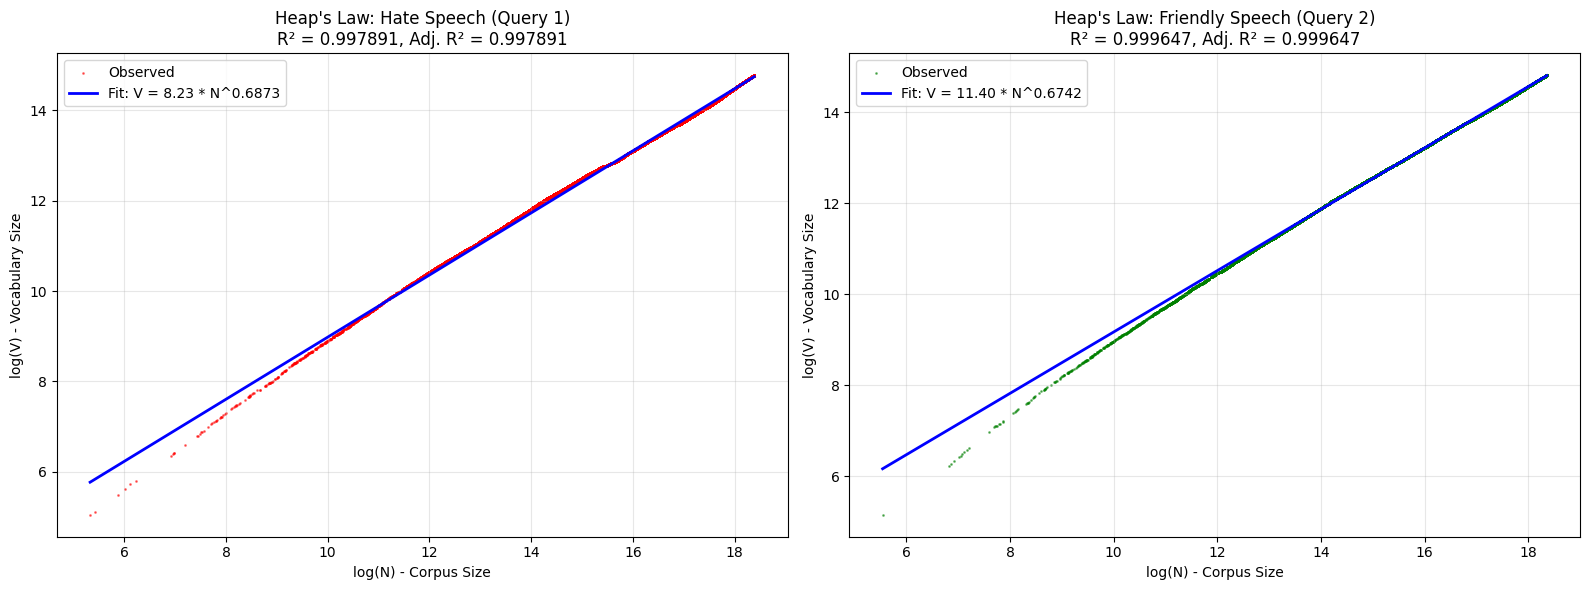

In [ ]:
# Plot Heap's Law in log-log space for both query types
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot for Hate Speech
ax1 = axes[0]
ax1.scatter(np.log(N_hate), np.log(V_hate), alpha=0.5, s=1, label='Observed', color='red')
log_N_hate = np.log(N_hate).reshape(-1, 1)
log_V_pred_hate = model_hate.predict(log_N_hate)
ax1.plot(np.log(N_hate), log_V_pred_hate, 'b-', linewidth=2, 
         label=f'Fit: V = {K_hate:.2f} * N^{beta_hate:.4f}')
ax1.set_xlabel('log(N) - Corpus Size')
ax1.set_ylabel('log(V) - Vocabulary Size')
ax1.set_title(f'Heap\'s Law: Hate Speech (Query 1)\nR² = {r2_hate:.6f}, Adj. R² = {adj_r2_hate:.6f}')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot for Friendly Speech
ax2 = axes[1]
ax2.scatter(np.log(N_friendly), np.log(V_friendly), alpha=0.5, s=1, label='Observed', color='green')
log_N_friendly = np.log(N_friendly).reshape(-1, 1)
log_V_pred_friendly = model_friendly.predict(log_N_friendly)
ax2.plot(np.log(N_friendly), log_V_pred_friendly, 'b-', linewidth=2,
         label=f'Fit: V = {K_friendly:.2f} * N^{beta_friendly:.4f}')
ax2.set_xlabel('log(N) - Corpus Size')
ax2.set_ylabel('log(V) - Vocabulary Size')
ax2.set_title(f'Heap\'s Law: Friendly Speech (Query 2)\nR² = {r2_friendly:.6f}, Adj. R² = {adj_r2_friendly:.6f}')0
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

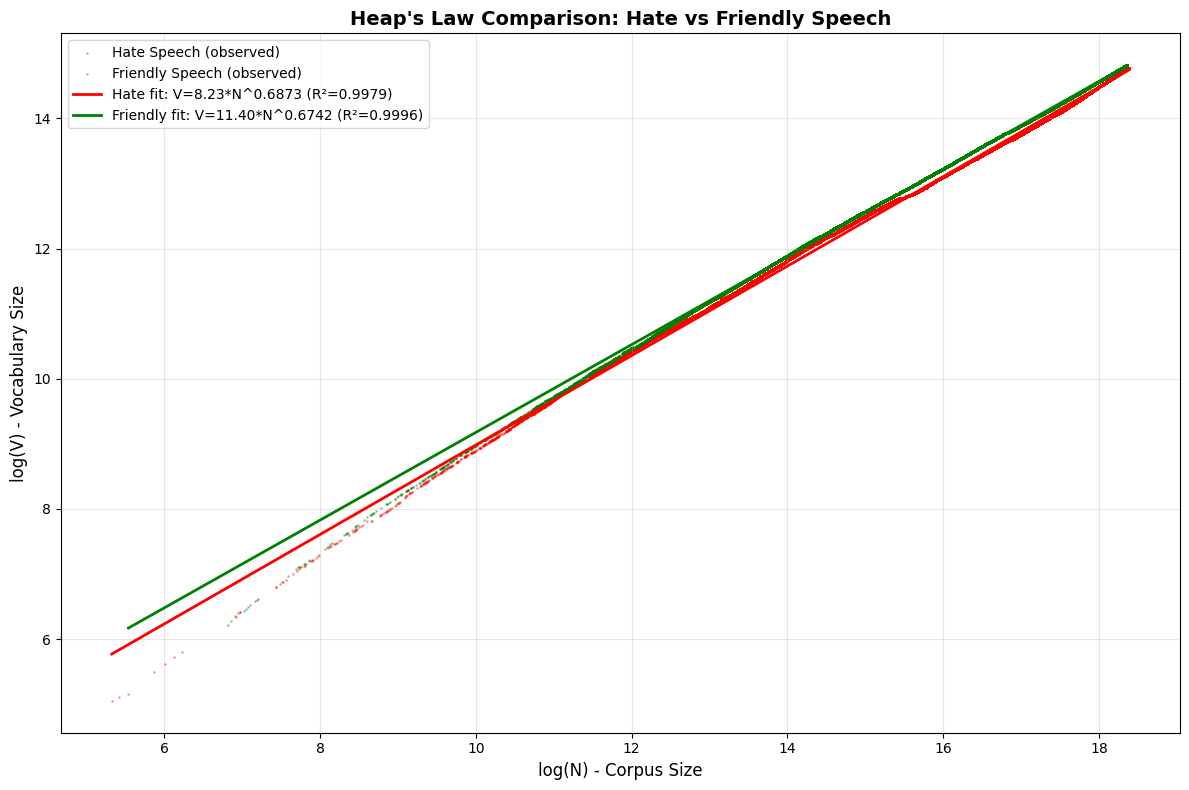

In [13]:
# Comparison plot: both query types on same axes
plt.figure(figsize=(12, 8))

# Plot both datasets
plt.scatter(np.log(N_hate), np.log(V_hate), alpha=0.3, s=1, label='Hate Speech (observed)', color='red')
plt.scatter(np.log(N_friendly), np.log(V_friendly), alpha=0.3, s=1, label='Friendly Speech (observed)', color='green')

# Plot fitted lines
plt.plot(np.log(N_hate), log_V_pred_hate, 'r-', linewidth=2, 
         label=f'Hate fit: V={K_hate:.2f}*N^{beta_hate:.4f} (R²={r2_hate:.4f})')
plt.plot(np.log(N_friendly), log_V_pred_friendly, 'g-', linewidth=2,
         label=f'Friendly fit: V={K_friendly:.2f}*N^{beta_friendly:.4f} (R²={r2_friendly:.4f})')

plt.xlabel('log(N) - Corpus Size', fontsize=12)
plt.ylabel('log(V) - Vocabulary Size', fontsize=12)
plt.title('Heap\'s Law Comparison: Hate vs Friendly Speech', fontsize=14, fontweight='bold')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [14]:
# Create summary table
summary_data = {
    'Query Type': ['Hate Speech (Query 1)', 'Friendly Speech (Query 2)'],
    'K (constant)': [f'{K_hate:.2f}', f'{K_friendly:.2f}'],
    'β (exponent)': [f'{beta_hate:.4f}', f'{beta_friendly:.4f}'],
    'R²': [f'{r2_hate:.6f}', f'{r2_friendly:.6f}'],
    'Adjusted R²': [f'{adj_r2_hate:.6f}', f'{adj_r2_friendly:.6f}'],
    'Sample Size': [len(N_hate), len(N_friendly)]
}

summary_df = pd.DataFrame(summary_data)
summary_df

,Query Type,K (constant),β (exponent),R²,Adjusted R²,Sample Size
0,Hate Speech (Query 1),8.23,0.6873,0.997891,0.997891,722384
1,Friendly Speech (Query 2),11.40,0.6742,0.999647,0.999647,609053
